<h1> Titanic - Machine Learning for Disaster </h1> 

In this project the intention is to make a predictive algorithm to predict whether an individual survived or not in the Titanic disaster. The following steps will be followed:

- Cleaning of data
- Drawing statistical insight from data 
- Understanding the important features 
- Applying different predictive algorithms to identify the best predictor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
training_data_raw = pd.read_csv(r'C:\Users\ASUS\Desktop\Kaggle\Titanic Dataset\train (1).csv')
training_data_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As **Pclass** and **SibSp** class are quite hard to interpret, we shall make these into more understandable column headings and replace them.

In [3]:
column_list = training_data_raw.columns.tolist()
column_list[2] = "Ticket Class"
column_list[6] = "Number of Siblings/Spouses aboard"
column_list[7] = "Number of Parents/Children aboard"
training_data_raw.columns = column_list
training_data_raw.head()

,PassengerId,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now we shall find which columns are missing data. The following philosophy will be used to fill missing data:

- The mean of a particular group will be used as a representative figure for a missing piece of data
- If the column has too much missing information in it, it will be removed from the analysis as it provides no valuable insight
- If data is missing in a column such as Age, the mean will be calculated based on groupby() function with respect to gender
- If data is missing in Fare class, the mean will be calculated based on the Ticket class.

Furthermore, data columns such as PassenderId and Ticket will not have any significant impact on the prediction. Hence they will be dropped. Neither is Port of Embarkation expected to have an impact, however this will be further investigated before being dropped. 

In [4]:
training_data_raw.drop(['PassengerId','Ticket'],axis = 1,inplace = True)


In [5]:
training_data_raw.head(10)

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,NaN,C


In [6]:
def numberofnan(dataset):
    
    column_labels = dataset.columns.tolist()
    num_missingvalues = list()
    percentage_missingvalues = list()
    for column in column_labels:
        num_missingvalues.append(dataset[column].isna().sum())
        percentage_missingvalues.append(100*(dataset[column].isna().sum())/dataset[column].shape[0])
    missing_value_percentage_df = pd.DataFrame({'Column Name':column_labels,'Number of Missing values':num_missingvalues,'% of missing values':percentage_missingvalues})
    return missing_value_percentage_df

In [8]:
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,177,19.8653
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,687,77.1044
9,Embarked,2,0.224467


There is a significant amount of missing values in **Cabin** and **Age**. **Embarked** only lacks 2 values which can be dropped off from the dataset.

In [9]:
training_data_raw.dropna(subset = ['Embarked'],inplace = True)
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,177,19.91
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,687,77.2778
9,Embarked,0,0


In [12]:
groupeddata = training_data_raw.groupby('Sex')

keylist = list()

for key,group in groupeddata:
    keylist.append(key)

In [13]:
groupeddata.get_group(keylist[0]).head()

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,NaN,C


In [14]:
groupeddata.get_group(keylist[1]).head()

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,NaN,S


In [15]:
#Average Female Age
import math
math.ceil(groupeddata.get_group(keylist[0])['Age'].mean())

28

In [16]:
math.ceil(groupeddata.get_group(keylist[1])['Age'].mean())

31

In [18]:
training_data_raw['Age'] = training_data_raw.groupby('Sex')['Age'].apply(lambda x:x.fillna(math.ceil(x.mean())))
training_data_raw.head(50)

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,31.0,0,0,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,NaN,C


In [19]:
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,0,0
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Cabin,687,77.2778
9,Embarked,0,0


Due to the very high number of missing values in the **Cabin** column and the lack of any correlation to conclusively fill the missing values, we shall drop this column

In [16]:
#groupedLotFrontageAverages = combinedfeatureset[['LotFrontage','Neighborhood']].groupby(['Neighborhood']).agg(Mean_Lot_Frontage = \
                                                                                                           #  pd.NamedAgg(column = \
                                                                                                        #    'LotFrontage',\
                                                                                                        #    aggfunc = np.mean))

In [22]:
training_data_raw.drop(['Cabin'],axis = 1,inplace = True)
training_data_raw.head()

,Survived,Ticket Class,Name,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [23]:
missing_data_df = numberofnan(training_data_raw)
display(missing_data_df.style.background_gradient(cmap = 'Reds',axis = 0))

,Column Name,Number of Missing values,% of missing values
0,Survived,0,0
1,Ticket Class,0,0
2,Name,0,0
3,Sex,0,0
4,Age,0,0
5,Number of Siblings/Spouses aboard,0,0
6,Number of Parents/Children aboard,0,0
7,Fare,0,0
8,Embarked,0,0


In [24]:
clean_dataset = training_data_raw

<h2> Investigating the effect gender had on the chance of surviving the disaster </h2>

In [25]:
survival_sex = pd.crosstab(clean_dataset['Sex'],clean_dataset['Survived'])
survival_sex

Survived,0,1
Sex,,
female,81,231
male,468,109


In [26]:
survival_sex.index.values.tolist()

['female', 'male']

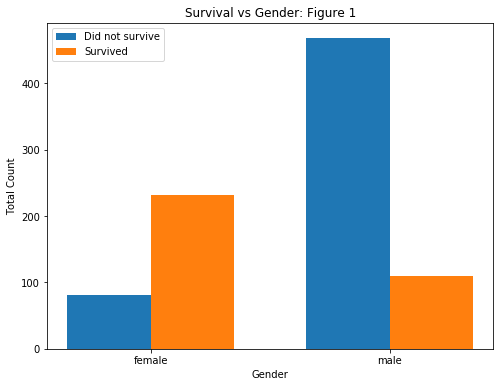

In [33]:
sex = np.arange(len(survival_sex.index.values))
width = 0.35

ax_sex = plt.figure(figsize = (8,6)).add_subplot(111)
ax_sex.bar(sex - width/2,survival_sex[0],width,label = 'Did not survive')
ax_sex.bar(sex + width/2,survival_sex[1],width,label = 'Survived')

ax_sex.set_title('Survival vs Gender: Figure 1')
ax_sex.set_xlabel('Gender')
ax_sex.set_ylabel('Total Count')
ax_sex.set_xticks(sex)
ax_sex.set_xticklabels(survival_sex.index.values.tolist())
ax_sex.legend()

Text(0.5, 0.98, 'Survival Probabilty vs Gender: Figure 2')

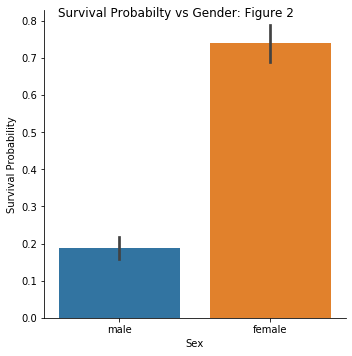

In [36]:
sex_survived = sns.factorplot(x = 'Sex',y = 'Survived',data = clean_dataset, kind = 'bar')
sex_survived.set_ylabels('Survival Probability')
sex_survived.fig.suptitle('Survival Probabilty vs Gender: Figure 2')

<h4>Discussion</h4> 

The results above show that:
- Males had a significant chance of not surviving the disaster. 
- More females survived the disaster than they passed away.

From Figure 2 we see that a male had a very low probability of surviving the disaster

<h4>To investigate the correlation between the gender and the survival rate, we can use the Chi Squared measurement</h4>

In [23]:
contingency_table = survival_sex.transpose().to_numpy()
contingency_table

array([[ 81, 468],
       [231, 109]], dtype=int64)

In [24]:
from scipy.stats import chi2_contingency
chi2val,p,dof,expected = chi2_contingency(contingency_table)

In [25]:
p

3.7799096665576e-58

In [26]:
chi2val

258.4266104463763

<h2>Investigating the effect Ticket Class had on the chance of surviving the disaster</h2>

In [40]:
survival_ticket = pd.crosstab(clean_dataset['Ticket Class'],clean_dataset['Survived'])
survival_ticket['% Died'] = 100*(survival_ticket[0]/survival_ticket.sum(axis = 1))
survival_ticket['% Survived'] = 100*(survival_ticket[1]/survival_ticket.sum(axis = 1))
survival_ticket

Survived,0,1,% Died,% Survived
Ticket Class,,,,
1,80,134,37.383178,53.305078
2,97,87,52.717391,36.752686
3,372,119,75.763747,20.996403


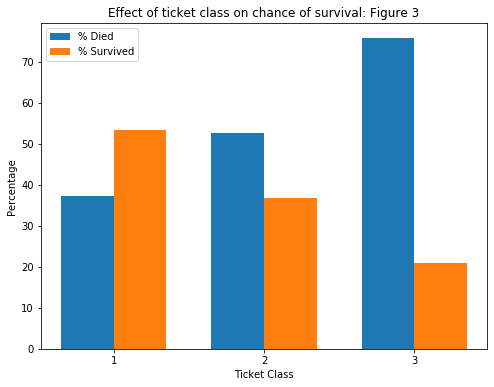

In [41]:
ax_ticketclass = plt.figure(figsize = (8,6)).add_subplot(111)

ticket_classes = np.arange(len(survival_ticket.index.values.tolist()))
width = 0.35

ax_ticketclass.bar(ticket_classes - width/2,survival_ticket['% Died'],width,label = '% Died')
ax_ticketclass.bar(ticket_classes + width/2,survival_ticket['% Survived'],width,label = '% Survived')
ax_ticketclass.set_title('Effect of ticket class on chance of survival: Figure 3')
ax_ticketclass.set_xlabel('Ticket Class')
ax_ticketclass.set_ylabel('Percentage')
ax_ticketclass.set_xticks(ticket_classes)
ax_ticketclass.set_xticklabels(survival_ticket.index.values.tolist())
ax_ticketclass.legend()

C:\Users\ASUS\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Survival Probabilty vs Ticket Class: Figure 4')

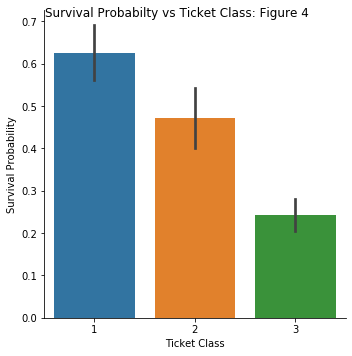

In [44]:
ax_pclass_sns = sns.factorplot(x = 'Ticket Class',y = 'Survived',data = clean_dataset,kind = 'bar')
ax_pclass_sns.set_ylabels('Survival Probability')
ax_pclass_sns.fig.suptitle('Survival Probabilty vs Ticket Class: Figure 4')

Intuitively there is a higher chance that fare and ticket class are correlated. Lets investigate that too

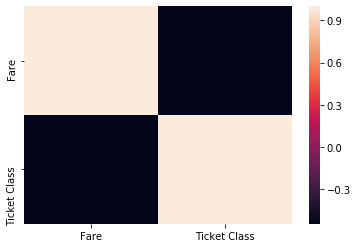

In [46]:
list1 = ['Fare','Ticket Class']
sns.heatmap(clean_dataset[list1].corr())

Intepreting the above heatmap is not straight forward as **Ticket Class** goes from First Class(1) to Third Class(3). Hence lower the ticket class in numerical terms, results in a higher price of the **Fare**. Hence it results in a strong negative correlation showing that Fare increases as Ticket Class goes from Third Class to First Class.

From the above analysis, we can say that paying a higher Fare for a ticket of a higher class had a higher chance of survival.

<h3> Investigating how Fare effected the chance of survival </h3>

Text(0.5, 1.0, 'Fare vs Survival: Figure 5')

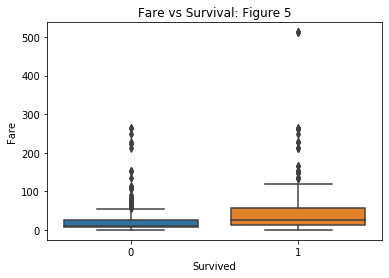

In [59]:
fare_grid = sns.boxplot(x = 'Survived',y = 'Fare',data = clean_dataset)
fare_grid.set_title('Fare vs Survival: Figure 5')

The above box plot in figure 5 shows that the Average Fare of an individual who survived is higher. Furthermore the 25th to 75th percentiles are much larger for the individuals who survived, with the 75th percentile and the Maximum (75th Percentile + 1.5* Interquartile Range) being much higher for the individuals that survived.

<h4>Discussion</h4>
An individual of the lower ticket class(3), had a lesser chance of surviving the disaster as compared to the an individual in the First Class. An individual in the second class however has an equal chance of both surviving and dying in the disaster. The First Class ticket holders have clearly been given priority in being saved. 


**Fare and Ticket Class can be used as features for prediction**

<h3> Extended Analysis </h3>

Earlier it was seen that more males died in the disaster. BUT did a first class ticket holder who was a male have a higher chance of surviving the disaster as compared to a male with a third class ticket?

In [66]:
extended_analysis_one = clean_dataset.loc[(clean_dataset['Sex'] == 'male') & ((clean_dataset['Ticket Class'].astype(int) == 1) | (clean_dataset['Ticket Class'].astype(int) == 2) | (clean_dataset['Ticket Class'].astype(int) == 3))]

In [67]:
extended_analysis_one_temp = pd.crosstab(extended_analysis_one['Ticket Class'],extended_analysis_one['Survived'])
extended_analysis_one_temp['% Died'] = 100*(extended_analysis_one_temp[0]/extended_analysis_one_temp.sum(axis = 1))
extended_analysis_one_temp['% Survived'] = 100*(extended_analysis_one_temp[1]/extended_analysis_one_temp.sum(axis = 1))
extended_analysis_one_temp

Survived,0,1,% Died,% Survived
Ticket Class,,,,
1,77,45,63.114754,24.309245
2,91,17,84.259259,8.842227
3,300,47,86.455331,10.843101


Text(0.5, 0.98, 'Survival Probabilty vs Ticket Class(Males): Figure 6')

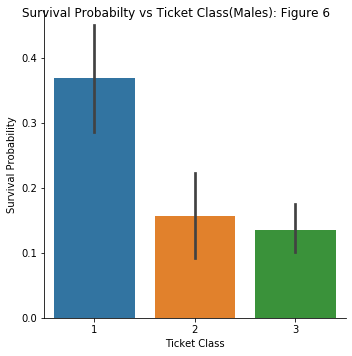

In [69]:
sns_male_extended = sns.factorplot(x = 'Ticket Class', y = 'Survived', data = extended_analysis_one, kind = 'bar')
sns_male_extended.set_ylabels('Survival Probability')
sns_male_extended.fig.suptitle('Survival Probabilty vs Ticket Class(Males): Figure 6')

Males in First Class also had higher death counts as compared to women, however a male in first class had a higher chance of surviving as compared to a male in Third Class

<h1>Investigating how having siblings/spouses affected chances of survival</h1>

In [71]:
survival_siblingsspouses = pd.crosstab(clean_dataset['Number of Siblings/Spouses aboard'],clean_dataset['Survived'])
survival_siblingsspouses

Survived,0,1
Number of Siblings/Spouses aboard,,
0,398,208
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


Text(0.5, 0.98, 'Survival Probabilty vs Number of Siblings/Spouse: Figure 7')

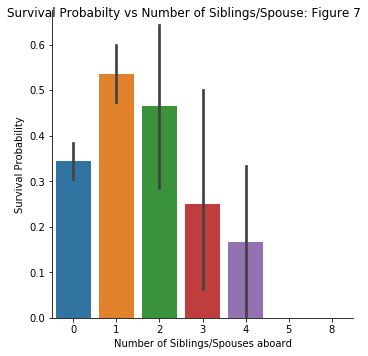

In [73]:
sns_siblings = sns.factorplot(x = 'Number of Siblings/Spouses aboard', y = 'Survived', data = clean_dataset, kind = 'bar')
sns_siblings.set_ylabels('Survival Probability')
sns_siblings.fig.suptitle('Survival Probabilty vs Number of Siblings/Spouse: Figure 7')

As shown by the above Table and Figure 7 show that **ideally you want only 1 sibling or spouse with you**. Having a higher number of siblings or a spouse than 1 decreases your chance of survival. 

Having 0 siblings and spouse resulted in lower chance of survival because you had no one to help you survive the disaster. 

<h1>Investigating how having children/parents affected chances of survival</h1>

In [74]:
survival_childrenparents = pd.crosstab(clean_dataset['Number of Parents/Children aboard'],clean_dataset['Survived'])
survival_childrenparents

Survived,0,1
Number of Parents/Children aboard,,
0,445,231
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


<h1> Investigating how age impacts the chance of survival </h1>

We shall use a box plot to visualize the average age of the ones who survived and died

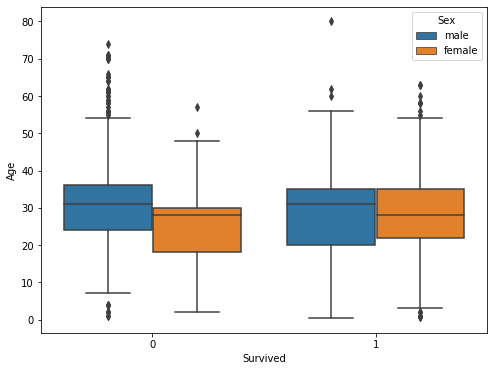

In [31]:
ax = plt.figure(figsize = (8,6)).add_subplot(111)

sns.boxplot(x = 'Survived', y = 'Age',data = clean_dataset, hue = 'Sex',ax = ax)

To further investigate how age and the chance of survival is correlated, the ages can be binned to age groups as follows:

- 0 to 12 years (Child)
- 13 to 18 years (Adolescence)
- 19 - 30 years(Young Adult)
- 30 - 60 years(Adult)
- 60 + (Senior)

In [32]:
age_analysis_dataset = clean_dataset.copy()
def splitagegroups(dataset):
    dataset.loc[(dataset['Age']>=0) & (dataset['Age']<12), 'Age Group'] = 'Child'
    dataset.loc[(dataset['Age']>=12) & (dataset['Age']<18), 'Age Group'] = 'Adolescence'
    dataset.loc[(dataset['Age']>=18) & (dataset['Age']<30), 'Age Group'] = 'Young Adult'
    dataset.loc[(dataset['Age']>=30) & (dataset['Age']<60), 'Age Group'] = 'Adult'
    dataset.loc[(dataset['Age']>=60), 'Age Group'] = 'Senior'
    return dataset

In [33]:
age_analysis_dataset_grouped = splitagegroups(age_analysis_dataset)
age_analysis_dataset_grouped

,Survived,Ticket Class,Sex,Age,Number of Siblings/Spouses aboard,Number of Parents/Children aboard,Fare,Embarked,Age Group
0,0,3,male,22.0,1,0,7.2500,S,Young Adult
1,1,1,female,38.0,1,0,71.2833,C,Adult
2,1,3,female,26.0,0,0,7.9250,S,Young Adult
3,1,1,female,35.0,1,0,53.1000,S,Adult
4,0,3,male,35.0,0,0,8.0500,S,Adult
5,0,3,male,31.0,0,0,8.4583,Q,Adult
6,0,1,male,54.0,0,0,51.8625,S,Adult
7,0,3,male,2.0,3,1,21.0750,S,Child
8,1,3,female,27.0,0,2,11.1333,S,Young Adult
9,1,2,female,14.0,1,0,30.0708,C,Adolescence


In [34]:
age_group_crosstab = pd.crosstab(age_analysis_dataset_grouped['Age Group'],age_analysis_dataset_grouped['Survived'])
age_group_crosstab

Survived,0,1
Age Group,,
Adolescence,23,22
Adult,285,142
Child,29,39
Senior,19,6
Young Adult,193,131


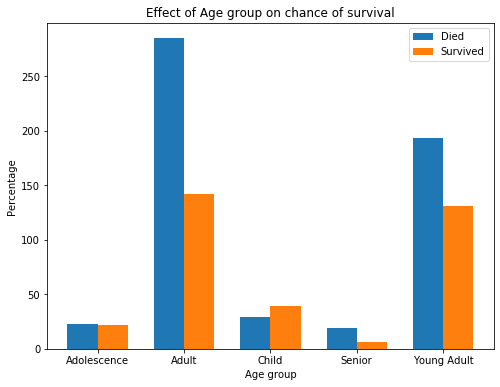

In [35]:
ax_agegroup = plt.figure(figsize = (8,6)).add_subplot(111)

agegroup_classes = np.arange(len(age_group_crosstab.index.values.tolist()))
width = 0.35

ax_agegroup.bar(agegroup_classes - width/2,age_group_crosstab[0],width,label = 'Died')
ax_agegroup.bar(agegroup_classes + width/2,age_group_crosstab[1],width,label = 'Survived')
ax_agegroup.set_title('Effect of Age group on chance of survival')
ax_agegroup.set_xlabel('Age group')
ax_agegroup.set_ylabel('Percentage')
ax_agegroup.set_xticks(agegroup_classes)
ax_agegroup.set_xticklabels(age_group_crosstab.index.values.tolist())
ax_agegroup.legend()

A Young adult or Adult had a higher chance of not surviving the disaster

In [36]:
age_analysis_dataset_grouped['Survived'].value_counts()

0    549
1    340
Name: Survived, dtype: int64

<h1> Building the pipelines for preprocessing </h1>

In [37]:
#Build a class to separate the numerical attributes and categorical attributes
from sklearn.base import BaseEstimator, TransformerMixin
class AttributeSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attributes):
        
        self.attributes = attributes
    def fit(self,X,y = None):
        return self
    def transform(self,X):
        return X[self.attributes]

In [38]:
from sklearn.pipeline import Pipeline


num_pipeline = Pipeline([('select_numeric_attributes',AttributeSelector(['Age','Number of Siblings/Spouses aboard','Number of Parents/Children aboard','Fare']))])

In [39]:
from sklearn.preprocessing import StandardScaler

num_attribute_dataset = num_pipeline.fit_transform(clean_dataset)
scl = StandardScaler()
scl.fit(num_attribute_dataset[['Age','Number of Siblings/Spouses aboard','Number of Parents/Children aboard','Fare']])
scaleddata = scl.transform(num_attribute_dataset[['Age','Number of Siblings/Spouses aboard','Number of Parents/Children aboard','Fare']])
num_attribute_dataset_scaled = scaleddata
num_attribute_dataset_scaled

array([[-0.59595394,  0.43135024, -0.47432585, -0.50023975],
       [ 0.63701176,  0.43135024, -0.47432585,  0.78894661],
       [-0.28771251, -0.47519908, -0.47432585, -0.48664993],
       ...,
       [-0.1335918 ,  0.43135024,  2.00611934, -0.17408416],
       [-0.28771251, -0.47519908, -0.47432585, -0.0422126 ],
       [ 0.17464963, -0.47519908, -0.47432585, -0.49017322]])

In [40]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([('select_categorical_attributes',AttributeSelector(['Ticket Class','Sex','Embarked'])),
                        ('onehotencorder',OneHotEncoder(sparse = False))])

In [41]:
cat_attribute_dataset = cat_pipeline.fit_transform(clean_dataset)

In [42]:
X_train = np.c_[num_attribute_dataset_scaled,cat_attribute_dataset]
y = clean_dataset['Survived']

In [71]:
X_train[0]

array([-0.59595394,  0.43135024, -0.47432585, -0.50023975,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ])

<h1> Models to be evaluated </h1>

- Logistic Regression with Lasso regularization
- SVM
- Random Forest
- Decision Tree

The Xtrain will be split into a training set and a testing set. To maintain equal ratio of 1/0, stratified splits are used.

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [45]:
y.value_counts(normalize = True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

Given that the data set contains 62% of 0s and 38% of 1s, the data is not skewed, hence accuracy is an acceptable technique to evaluate the performance of the model

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter =  StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)

for train_index,test_index in splitter.split(X_train,y):
    x_train = X_train[train_index]
    y_train = y[train_index]
    x_test = X_train[test_index]
    y_test = y[test_index]

C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [47]:
y_test.value_counts(normalize = True)

0    0.606742
1    0.393258
Name: Survived, dtype: float64

In [48]:
y_train.value_counts(normalize = True)

0.0    0.619048
1.0    0.380952
Name: Survived, dtype: float64

In [49]:
np.isnan(y_train).sum()
np.where(np.isnan(y_train))

(array([ 37, 630], dtype=int64),)

In [50]:
y_train = np.nan_to_num(y_train)

In [51]:
np.isnan(y_train).sum()

0

In [52]:
from sklearn.svm import SVC
#x_train = x_train[np.where(~np.isnan(y_train))[0]]
#y_train = y_train[np.where(~np.isnan(y_train))[0]]
svm_clf = SVC(kernel = 'rbf')
svm_clf.fit(x_train,y_train)

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

<h5>Predicting using a model with no manipulation in hyperparameters</h5>

In [53]:
y_pred = svm_clf.predict(x_train)

<h6> Accuracy Score </h6>

In [54]:
accuracy_score(y_train,y_pred)

0.6225

In [55]:
confusion_matrix(y_train,y_pred)

array([[496,   0],
       [302,   2]], dtype=int64)

In [56]:
precision_score(y_train,y_pred,average = 'weighted')

0.7653634085213032

<h4> Tuning the hyperparameters of a SVM classifier </h4>

In [57]:
from sklearn.model_selection import RandomizedSearchCV

In [58]:
from scipy.stats import reciprocal, uniform
parameters = {'kernel':['rbf','poly'],'gamma':reciprocal(0.0001,10),'C':uniform(0.1,10)}

In [59]:
svc_rnd = SVC()
random_search = RandomizedSearchCV(svc_rnd,parameters,n_iter = 10,verbose = 2,cv=4)
random_search.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly ..
[CV]  C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly, total=   0.0s
[CV] C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly ..
[CV]  C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly, total=   0.0s
[CV] C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly ..
[CV]  C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly, total=   0.0s
[CV] C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly ..
[CV]  C=1.6271276529750978, gamma=0.0012431457724088417, kernel=poly, total=   0.0s
[CV] C=9.96504100131867, gamma=0.001112909892805356, kernel=poly .....
[CV]  C=9.96504100131867, gamma=0.001112909892805356, kernel=poly, total=   0.0s
[CV] C=9.96504100131867, gamma=0.001112909892805356, kernel=poly .....
[CV]  C=9.96504100131867, gamma=0.001112909892805356, kernel=poly, total=   0.0s
[CV] C=9.965041

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EA60309898>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EA60309240>,
                                        'kernel': ['rbf', 'poly']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [61]:
random_search.cv_results_

{'mean_fit_time': array([0.00700343, 0.00572371, 0.01371098, 0.01495016, 0.0179525 ,
        0.01595807, 0.00847936, 0.00648391, 0.00698185, 0.00598401]),
 'std_fit_time': array([7.22035099e-04, 4.25634694e-04, 1.08285082e-03, 1.22241344e-03,
        1.41183543e-03, 1.22105504e-03, 5.00691788e-04, 4.96159904e-04,
        1.39020727e-06, 4.57831964e-07]),
 'mean_score_time': array([0.00173259, 0.00149632, 0.00276321, 0.0027433 , 0.00274539,
        0.00274175, 0.00199336, 0.00174594, 0.00099713, 0.00174534]),
 'std_score_time': array([4.24911107e-04, 4.98653726e-04, 4.16767385e-04, 4.32258781e-04,
        4.33503561e-04, 4.31504083e-04, 7.56838177e-06, 4.27425435e-04,
        1.01677907e-06, 4.31880153e-04]),
 'param_C': masked_array(data=[1.6271276529750978, 9.96504100131867, 5.444096024764,
                    9.288143809498841, 10.013936310027166,
                    7.201030907506613, 2.9586183066638205,
                    8.399311745576599, 6.680806471195563,
                    4

In [62]:
random_search.best_estimator_

SVC(C=1.6271276529750978, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0012431457724088417,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [64]:
random_search.best_score_

0.62

After carrying out RandomizedSearchCV to tune the hyperparameters, the SVM provides only a score of 62% after being evaluated using 4 fold cross validation. 

In [68]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1',solver = 'liblinear')

In [69]:
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
lr.coef_

array([[-0.03727918, -0.28242846,  0.06746769,  0.03231892,  0.        ,
        -0.37386306, -0.1144374 ,  0.        , -0.14494103, -0.11650427,
         0.00207983, -0.16246618]])

The coefficients were arrange in this order:

- Age|Sibling/spouse|Children/parents|Fare|Class 1|Class 2|Class 3|Female|Male|Port 1|Port 2|Port3

As per Logistic Regression with Lasso Regularization, feature selection indicates that Class 1 attribute and Female attribute do not have a significant impact on prediction

In [72]:
parameters = {'C':uniform(0.01,10)}
random_search_lr = RandomizedSearchCV(lr,parameters,n_iter = 10,verbose = 2,cv=4)
random_search_lr.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] C=4.82727679063888 ..............................................
[CV] ............................... C=4.82727679063888, total=   0.0s
[CV] C=4.82727679063888 ..............................................
[CV] ............................... C=4.82727679063888, total=   0.0s
[CV] C=4.82727679063888 ..............................................
[CV] ............................... C=4.82727679063888, total=   0.0s
[CV] C=4.82727679063888 ..............................................
[CV] ............................... C=4.82727679063888, total=   0.0s
[CV] C=9.825513806713865 .............................................
[CV] .............................. C=9.825513806713865, total=   0.0s
[CV] C=9.825513806713865 .............................................
[CV] .............................. C=9.825513806713865, total=   0.0s
[CV] C=9.825513806713865 .............................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l1', random_state=None,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EA5FBDE828>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [75]:
random_search_lr.best_estimator_

LogisticRegression(C=4.82727679063888, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
random_search_lr.best_score_

0.605

In [77]:
y_pred = random_search_lr.best_estimator_.predict(x_train)

In [78]:
confusion_matrix(y_train,y_pred)

array([[485,  11],
       [296,   8]], dtype=int64)

0.61625